In [170]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import xgboost as xgb


import os
import warnings

from pathlib import Path

#Configurations
warnings.filterwarnings('ignore')
%matplotlib inline
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)

## Directories and Filenames
Contains paths and filenames to access test and training data.

In [171]:
ROOT_DIR = Path.cwd().parent
SRC_DIR = os.path.join(ROOT_DIR, 'src')
DATA_DIR = os.path.join(ROOT_DIR, 'data')

processed_training_data_path = os.path.join(DATA_DIR, 'train_processed.csv')
processed_test_data_path = os.path.join(DATA_DIR, 'test_processed.csv')

In [172]:
df_train = pd.read_csv(processed_training_data_path)
df_unseen_test = pd.read_csv(processed_test_data_path)

In [173]:
x7_cols = [col for col in df_train.columns if col.startswith('x7_')]

df_train_polka = df_train[df_train['x7_Polka'] == 1]
df_train_polka = df_train_polka.drop(x7_cols, axis=1)

df_train_slängpolskor = df_train[df_train['x7_Slängpolskor'] == 1]
df_train_slängpolskor = df_train_slängpolskor.drop(x7_cols, axis=1)

df_train_schottis = df_train[df_train['x7_Schottis'] == 1]
df_train_schottis = df_train_schottis.drop(x7_cols, axis=1)

df_train_polskor = df_train[df_train['x7_Polskor'] == 1]
df_train_polskor = df_train_polskor.drop(x7_cols, axis=1)

df_train_hambo = df_train[df_train['x7_Hambo'] == 1]
df_train_hambo = df_train_hambo.drop(x7_cols, axis=1)

## Train, Validation and Test Splits & Modeling

In [174]:
df_test = df_train.sample(frac=0.2, random_state=42)
df_train = df_train.drop(df_test.index)

print(f"Train shape: {df_train.shape}")
print(f"Test shape: {df_test.shape}")
print(f"Unseen test shape: {df_unseen_test.shape}")

df_train.head()

Train shape: (790, 18)
Test shape: (197, 18)
Unseen test shape: (9902, 17)


x7_Hambo  x7_Polka  x7_Polskor  x7_Schottis  x7_Slängpolskor  x12_True  \
0       0.0       0.0         0.0          0.0              1.0       1.0   
1       1.0       0.0         0.0          0.0              0.0       1.0   
2       0.0       0.0         0.0          1.0              0.0       1.0   
3       0.0       0.0         0.0          0.0              1.0       1.0   
4       0.0       0.0         0.0          1.0              0.0       1.0   

         x1        x2        x3        x4        x5        x6        x8  \
0 -0.217610  1.198357 -1.172690  0.041297  0.168716  0.987879  1.243974   
1 -1.723374  0.037146  0.639590  0.505788 -0.394709  0.235030 -0.343594   
2  0.815268 -0.401341  1.466614  0.476071 -0.055452 -0.279269  0.888450   
3 -0.456902  1.890258  0.383763  0.279145 -0.166733  1.651127 -0.935800   
4  0.878887 -1.381426 -0.539423  0.952232 -1.010925 -1.574866 -1.471067   

         x9       x10       x11       x13  y  
0  0.323734 -0.275316 -0.462594 -0.640260  2  
1 -0.401810 -0.042394  0.763768 -1.584218  0  
2  0.078986 -1.363136 -0.845952  1.370782  1  
3 -0.617531  0.041439 -0.285398 -0.344786  2  
4  1.137805  0.408868 -0.852787  0.733035  1

In [175]:
from sklearn.ensemble import RandomForestClassifier

def train_different_models(x_train, y_train):
    
    from sklearn.model_selection import GridSearchCV

    xgb_model = xgb.XGBClassifier(objective='multi:softmax', random_state=42, n_jobs=-1)
    parameters = {
        'n_estimators': [30, 50, 70, 100, 200, 300],
        'max_depth': [3, 5, 7, 8, 10, 15],
        'learning_rate': [0.01, 0.05, 0.1, 0.2],
    }

    rf_model = RandomForestClassifier(random_state=42, n_jobs=-1)
    parameters = {
        'n_estimators': [30, 50, 75, 100, 200],
        'max_depth': [3, 5, 7, 10],
        'max_features': ['sqrt', 'log2'],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
    }

    #Define custom scoring function according to weighted f1 score for each class
    from sklearn.metrics import f1_score, make_scorer

    def weighted_f1_score(y_true, y_pred):
        return f1_score(y_true, y_pred, average='weighted')

    scoring = make_scorer(weighted_f1_score, greater_is_better=True)

    xgb_cv = GridSearchCV(xgb_model, parameters, cv=10, n_jobs=-1, scoring=scoring)
    xgb_cv.fit(x_train, y_train)
    print(f"best model score: {xgb_cv.best_score_}")

    rf_cv = GridSearchCV(rf_model, parameters, cv=10, n_jobs=-1, scoring=scoring)
    rf_cv.fit(x_train, y_train)
    print(f"best model score: {rf_cv.best_score_}")

    return xgb_cv, rf_cv

In [176]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report, f1_score

def evaluate_model(model_predictions, model_labels, model):
    fig, ax = plt.subplots(figsize=(12, 8))
    cm = confusion_matrix(model_labels, model_predictions)
    cmp = ConfusionMatrixDisplay(cm, display_labels=model.classes_)
    cmp.plot(ax=ax)
    plt.show()

    #print(classification_report(model_labels, model_predictions))
    print(f"Weighted F1 Score across all classes: {f1_score(model_labels, model_predictions, average='weighted')}")
    return f1_score(model_labels, model_predictions, average='weighted')

def train_and_evaluate_different_models_for_each_x5(dataframes):
    xgb_models = {}
    rf_models = {}
    f1_scores_xgb = {}
    f1_scores_rf = {}

    for df in dataframes:
        x_train, x_val, y_train, y_val = train_test_split(df.drop(['y'], axis=1), df['y'], test_size=0.2, random_state=42, stratify=df['y'])
        print(f"Train shape: {x_train.shape}")
        print(f"Train shape: {y_train.shape}")
        print(f"Validation shape: {x_val.shape}")
        print(f"Validation shape: {y_val.shape}")
        xgb_model, rf_model = train_different_models(x_train, y_train)
        xgb_models[f"{df}_xgb"] = xgb_model
        rf_models[f"{df}_rf"] = rf_model

        xgb_predictions = xgb_model.predict(x_val)
        rf_predictions = rf_model.predict(x_val)

        print(f"XGB Model for {df}")
        f1_scores_xgb[f"{df}_xgb"] = evaluate_model(xgb_predictions, y_val, xgb_model)

        print(f"RF Model for {df}")
        f1_scores_rf[f"{df}_rf"] = evaluate_model(rf_predictions, y_val, rf_model)

    return xgb_models, rf_models


Train shape: (201, 12)
Train shape: (201,)
Validation shape: (51, 12)
Validation shape: (51,)
[12:31:13] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[12:31:13] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[12:31:13] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[12:31:13] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[1

/Users/michaelfuest/.pyenv/versions/3.11.0/envs/multilabel/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/michaelfuest/.pyenv/versions/3.11.0/envs/multilabel/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/michaelfuest/.pyenv/versions/3.11.0/envs/multilabel/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed

best model score: 0.6870661029791465
XGB Model for      x12_True        x1        x2        x3        x4        x5        x6  \
6         1.0  0.125047  0.506918 -0.554471  1.383780 -1.526973 -0.588505   
8         1.0  0.000289  0.136432 -1.347717  0.415807 -0.491811  0.188703   
10        1.0  0.418130 -1.874360  1.294433  0.173108  0.186943 -1.202362   
18        0.0  0.315951  1.436026 -0.013351  0.168568 -0.040099  2.910231   
21        1.0  0.708546 -1.164904 -1.875214  1.039237 -0.966278 -1.255149   
..        ...       ...       ...       ...       ...       ...       ...   
966       1.0  0.076807  1.017135  0.559628 -1.390897  1.444213  1.729185   
971       1.0  0.068382 -0.661124 -0.485670  1.265223 -1.257368 -0.107088   
974       1.0  0.220677 -0.791642 -0.321733  0.396080 -0.289224 -0.985141   
975       0.0  0.028004 -0.934869  0.255511 -0.441453  0.701291 -0.295607   
984       1.0  0.176329 -0.300041 -0.837632 -0.037980 -0.222254 -0.535661   

           x8        x9 

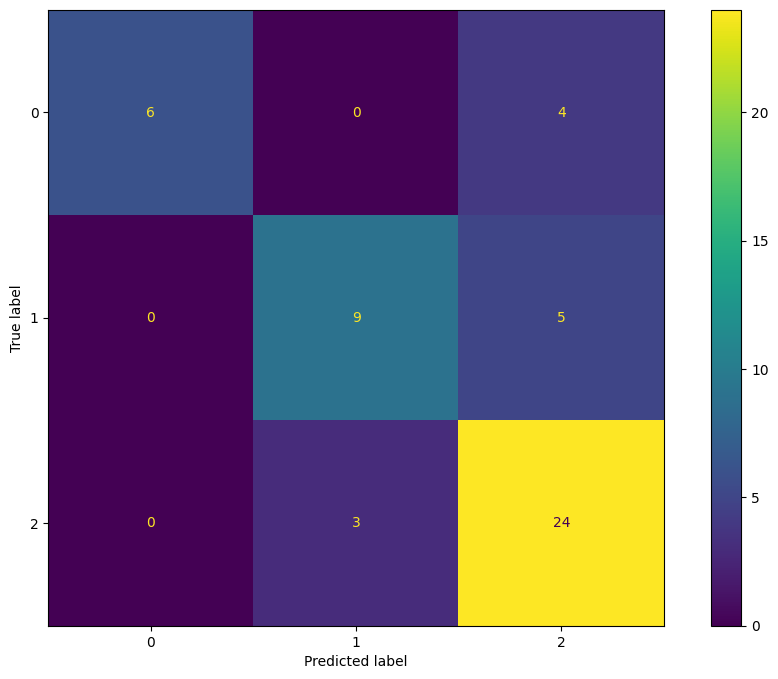

Weighted F1 Score across all classes: 0.7606334841628959
RF Model for      x12_True        x1        x2        x3        x4        x5        x6  \
6         1.0  0.125047  0.506918 -0.554471  1.383780 -1.526973 -0.588505   
8         1.0  0.000289  0.136432 -1.347717  0.415807 -0.491811  0.188703   
10        1.0  0.418130 -1.874360  1.294433  0.173108  0.186943 -1.202362   
18        0.0  0.315951  1.436026 -0.013351  0.168568 -0.040099  2.910231   
21        1.0  0.708546 -1.164904 -1.875214  1.039237 -0.966278 -1.255149   
..        ...       ...       ...       ...       ...       ...       ...   
966       1.0  0.076807  1.017135  0.559628 -1.390897  1.444213  1.729185   
971       1.0  0.068382 -0.661124 -0.485670  1.265223 -1.257368 -0.107088   
974       1.0  0.220677 -0.791642 -0.321733  0.396080 -0.289224 -0.985141   
975       0.0  0.028004 -0.934869  0.255511 -0.441453  0.701291 -0.295607   
984       1.0  0.176329 -0.300041 -0.837632 -0.037980 -0.222254 -0.535661   

     

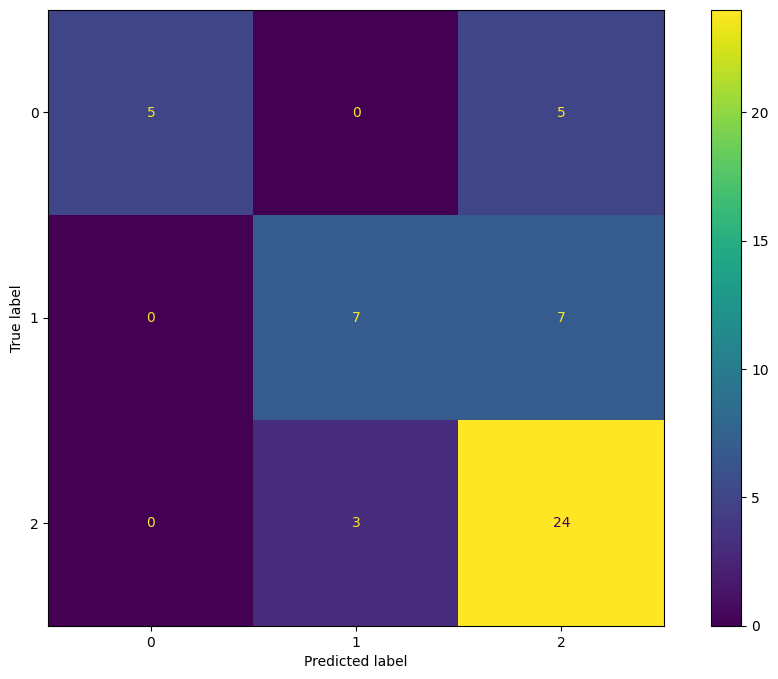

Weighted F1 Score across all classes: 0.6942110177404295
Train shape: (216, 12)
Train shape: (216,)
Validation shape: (54, 12)
Validation shape: (54,)
[12:33:53] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[12:33:53] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[12:33:53] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[12:33:53] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "max_features", "m

/Users/michaelfuest/.pyenv/versions/3.11.0/envs/multilabel/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/michaelfuest/.pyenv/versions/3.11.0/envs/multilabel/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/michaelfuest/.pyenv/versions/3.11.0/envs/multilabel/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed

best model score: 0.6985441246653985
XGB Model for      x12_True        x1        x2        x3        x4        x5        x6  \
0         1.0 -0.217610  1.198357 -1.172690  0.041297  0.168716  0.987879   
3         1.0 -0.456902  1.890258  0.383763  0.279145 -0.166733  1.651127   
5         1.0 -0.423488 -0.796758  0.158437 -0.894777  0.921842 -0.467800   
9         1.0 -0.029076  0.777887 -1.480862  0.229218 -0.287476  0.411814   
13        1.0 -0.542695 -1.084384  1.680528 -1.405485  1.437794 -1.980151   
..        ...       ...       ...       ...       ...       ...       ...   
970       1.0 -0.358240 -0.907448 -1.665172 -0.567469  1.085410 -0.912176   
972       0.0 -0.564987 -1.431192  0.854354 -0.205517 -0.150661 -1.861406   
976       1.0 -0.329458  0.462936 -2.833240 -0.375490  0.045051 -0.034761   
980       1.0 -0.258540 -1.388638 -0.445359 -0.995094  0.759997 -1.535991   
985       1.0 -0.243083  0.137997 -0.158175 -1.892292  1.736021  0.054873   

           x8        x9 

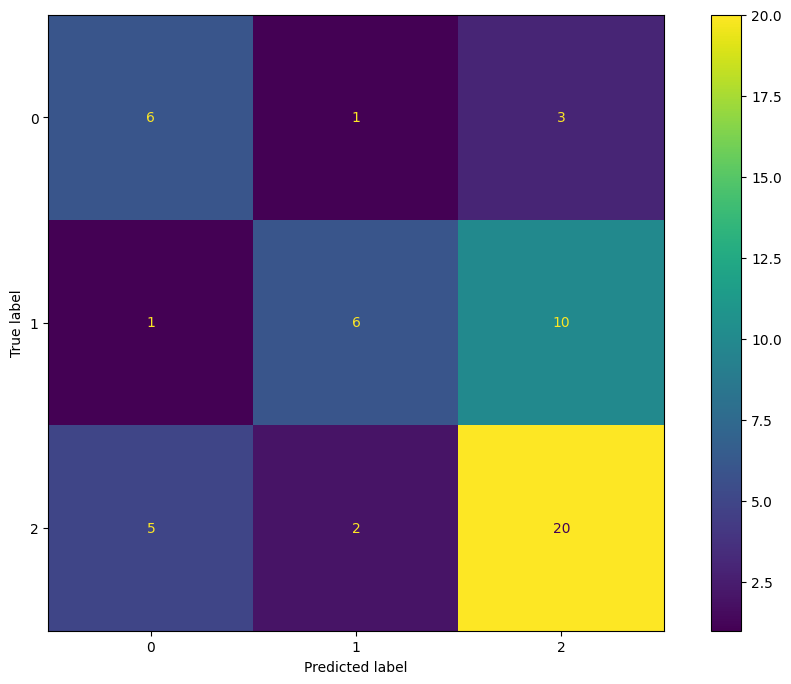

Weighted F1 Score across all classes: 0.5796425796425796
RF Model for      x12_True        x1        x2        x3        x4        x5        x6  \
0         1.0 -0.217610  1.198357 -1.172690  0.041297  0.168716  0.987879   
3         1.0 -0.456902  1.890258  0.383763  0.279145 -0.166733  1.651127   
5         1.0 -0.423488 -0.796758  0.158437 -0.894777  0.921842 -0.467800   
9         1.0 -0.029076  0.777887 -1.480862  0.229218 -0.287476  0.411814   
13        1.0 -0.542695 -1.084384  1.680528 -1.405485  1.437794 -1.980151   
..        ...       ...       ...       ...       ...       ...       ...   
970       1.0 -0.358240 -0.907448 -1.665172 -0.567469  1.085410 -0.912176   
972       0.0 -0.564987 -1.431192  0.854354 -0.205517 -0.150661 -1.861406   
976       1.0 -0.329458  0.462936 -2.833240 -0.375490  0.045051 -0.034761   
980       1.0 -0.258540 -1.388638 -0.445359 -0.995094  0.759997 -1.535991   
985       1.0 -0.243083  0.137997 -0.158175 -1.892292  1.736021  0.054873   

     

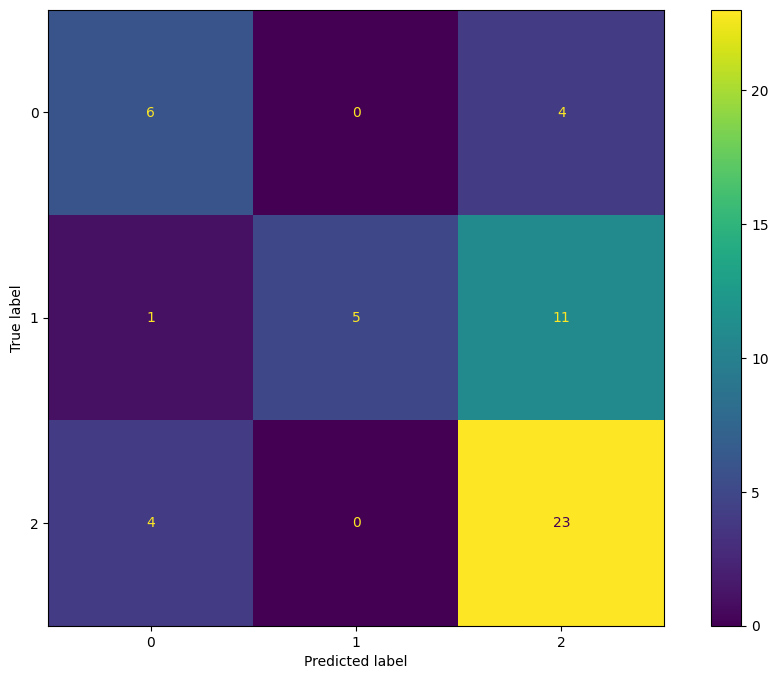

Weighted F1 Score across all classes: 0.6027639027639027
Train shape: (125, 12)
Train shape: (125,)
Validation shape: (32, 12)
Validation shape: (32,)
[12:36:31] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[12:36:31] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[12:36:31] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[12:36:31] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "max_features", "m

/Users/michaelfuest/.pyenv/versions/3.11.0/envs/multilabel/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/michaelfuest/.pyenv/versions/3.11.0/envs/multilabel/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/michaelfuest/.pyenv/versions/3.11.0/envs/multilabel/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed

best model score: 0.6664216609182672
XGB Model for      x12_True        x1        x2        x3        x4        x5        x6  \
2         1.0  0.815268 -0.401341  1.466614  0.476071 -0.055452 -0.279269   
4         1.0  0.878887 -1.381426 -0.539423  0.952232 -1.010925 -1.574866   
11        0.0  1.033315  1.190954  0.273839  0.604366 -0.621296  1.595013   
12        1.0  1.353837 -0.344649 -0.941812  1.263716 -1.116578  0.631929   
16        1.0  1.140857 -1.059794  3.154202 -2.421317  2.280093  0.745227   
..        ...       ...       ...       ...       ...       ...       ...   
943       1.0  0.805875  0.078161 -0.365724 -0.448409  0.427159 -0.009615   
956       0.0  0.786072 -0.444276  0.390741  0.321247 -0.677344 -0.256972   
969       1.0  1.005689 -0.689634  0.121173 -0.598577  1.013482 -0.296337   
978       0.0  0.787800  0.128458  0.329340  1.454709 -1.633153 -1.182981   
979       1.0  0.835200  0.299405 -0.422243 -0.810573  0.949770  0.048185   

           x8        x9 

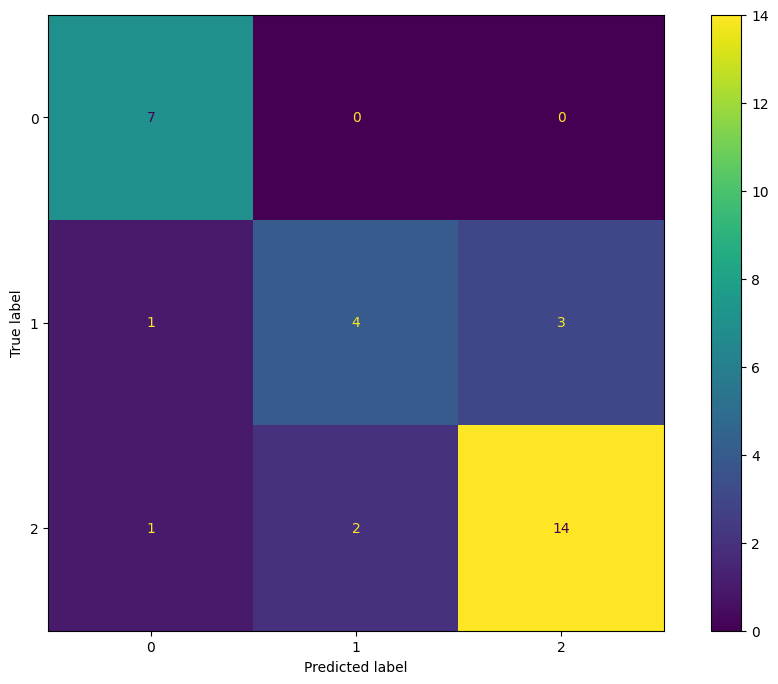

Weighted F1 Score across all classes: 0.7717633928571429
RF Model for      x12_True        x1        x2        x3        x4        x5        x6  \
2         1.0  0.815268 -0.401341  1.466614  0.476071 -0.055452 -0.279269   
4         1.0  0.878887 -1.381426 -0.539423  0.952232 -1.010925 -1.574866   
11        0.0  1.033315  1.190954  0.273839  0.604366 -0.621296  1.595013   
12        1.0  1.353837 -0.344649 -0.941812  1.263716 -1.116578  0.631929   
16        1.0  1.140857 -1.059794  3.154202 -2.421317  2.280093  0.745227   
..        ...       ...       ...       ...       ...       ...       ...   
943       1.0  0.805875  0.078161 -0.365724 -0.448409  0.427159 -0.009615   
956       0.0  0.786072 -0.444276  0.390741  0.321247 -0.677344 -0.256972   
969       1.0  1.005689 -0.689634  0.121173 -0.598577  1.013482 -0.296337   
978       0.0  0.787800  0.128458  0.329340  1.454709 -1.633153 -1.182981   
979       1.0  0.835200  0.299405 -0.422243 -0.810573  0.949770  0.048185   

     

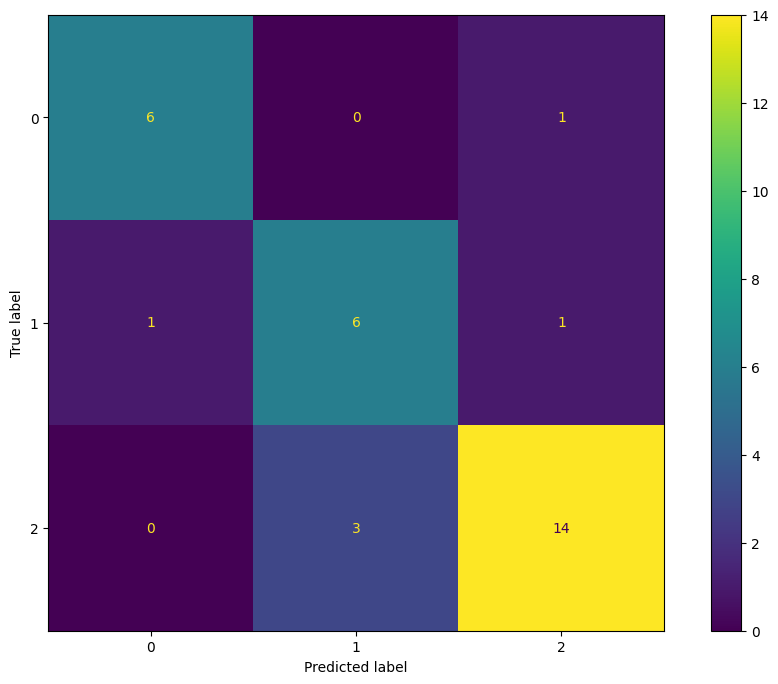

Weighted F1 Score across all classes: 0.8147281639928698
Train shape: (62, 12)
Train shape: (62,)
Validation shape: (16, 12)
Validation shape: (16,)
[12:38:42] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[12:38:42] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[12:38:42] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[12:38:42] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "max_features", "min

/Users/michaelfuest/.pyenv/versions/3.11.0/envs/multilabel/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/michaelfuest/.pyenv/versions/3.11.0/envs/multilabel/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/michaelfuest/.pyenv/versions/3.11.0/envs/multilabel/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed

In [177]:
#Train and evaluate separate models
xgb_models, rf_models = train_and_evaluate_different_models_for_each_x5([df_train_polka, df_train_slängpolskor, df_train_schottis, df_train_polskor, df_train_hambo])

## Model Evaluation

Evaluating random forest multiclass classifier and xgboost multiclass classifier according to predictions made by the best estimator obtained in f1 score scored grid search. 

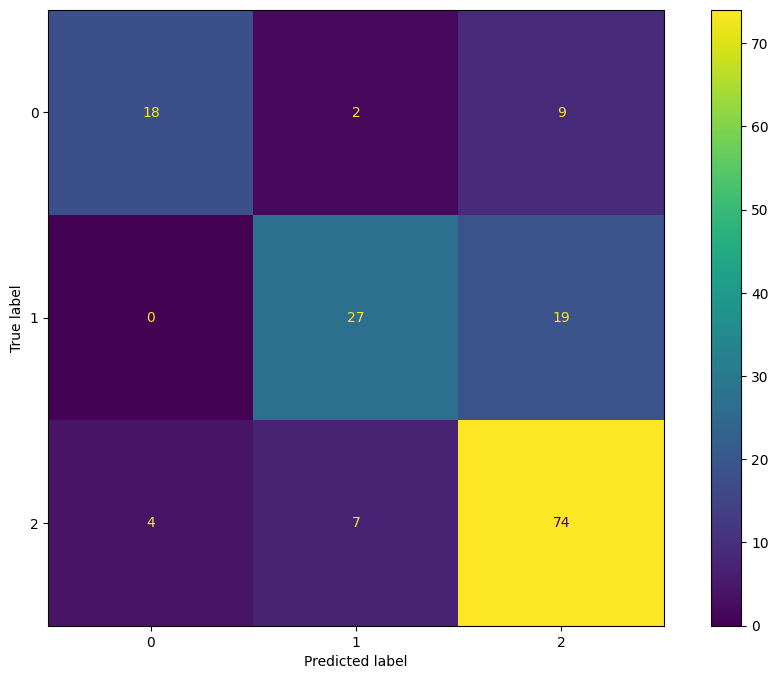

              precision    recall  f1-score   support

           0       0.82      0.62      0.71        29
           1       0.75      0.59      0.66        46
           2       0.73      0.87      0.79        85

    accuracy                           0.74       160
   macro avg       0.76      0.69      0.72       160
weighted avg       0.75      0.74      0.74       160

Weighted F1 Score across all classes: 0.7377249902178166


0.7377249902178166

In [ ]:
evaluate_model(y_pred_rf, y_val, rf_cv.best_estimator_)

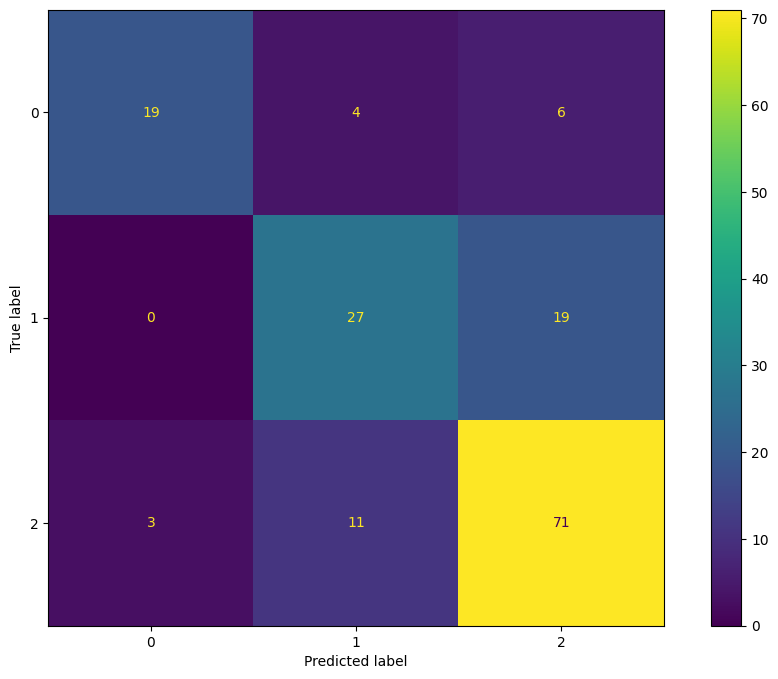

              precision    recall  f1-score   support

           0       0.86      0.66      0.75        29
           1       0.64      0.59      0.61        46
           2       0.74      0.84      0.78        85

    accuracy                           0.73       160
   macro avg       0.75      0.69      0.71       160
weighted avg       0.73      0.73      0.73       160

Weighted F1 Score across all classes: 0.7282512421090989


0.7282512421090989

In [ ]:
evaluate_model(y_pred_xgb, y_val, xgb_cv.best_estimator_)

In [ ]:
df_val = pd.DataFrame(x_val)
df_val['y'] = y_val
df_val['xgb_pred'] = y_pred_xgb
df_val['rf_pred'] = y_pred_rf

df_val.head()

x7_Hambo  x7_Polka  x7_Polskor  x7_Schottis  x7_Slängpolskor  x12_True  \
393       0.0       0.0         0.0          1.0              0.0       0.0   
170       0.0       1.0         0.0          0.0              0.0       1.0   
250       0.0       0.0         0.0          1.0              0.0       1.0   
766       0.0       0.0         1.0          0.0              0.0       1.0   
692       0.0       0.0         1.0          0.0              0.0       1.0   

           x1        x2        x3        x4        x5        x6        x8  \
393 -0.031616  1.779698 -0.066377  0.031654 -0.721904  0.770888 -2.082192   
170 -0.031654  0.440899  0.594506  0.031654 -1.488639  0.653564 -1.592195   
250 -0.031621 -0.143079 -0.062093  0.031654 -0.259052 -0.547100 -0.013786   
766 -0.031594  1.027025  1.776693  0.031654  0.145274  1.320620  1.735263   
692 -0.031579  0.774512 -1.865681  0.031654 -0.086463  0.410917  0.206944   

           x9       x10       x11       x13  y  xgb_pred  rf_pred  
393 -2.069051 -2.245021  1.848495  1.212923  2         2        2  
170  2.012139 -0.110034 -1.016679  0.228910  1         2        1  
250  0.354768  1.025353 -0.455631  1.080156  1         2        2  
766 -0.663801  0.281603  0.590905  2.581549  2         2        2  
692 -1.056436 -0.081528 -0.938820  1.809401  2         2        1

In [ ]:
#Get prediction error rate by class
df_val['xgb_error'] = df_val['y'] != df_val['xgb_pred']
df_val.groupby(['y', 'xgb_error']).count()['xgb_pred']

y  xgb_error
0  False        19
   True         10
1  False        27
   True         19
2  False        71
   True         14
Name: xgb_pred, dtype: int64

<Axes: >

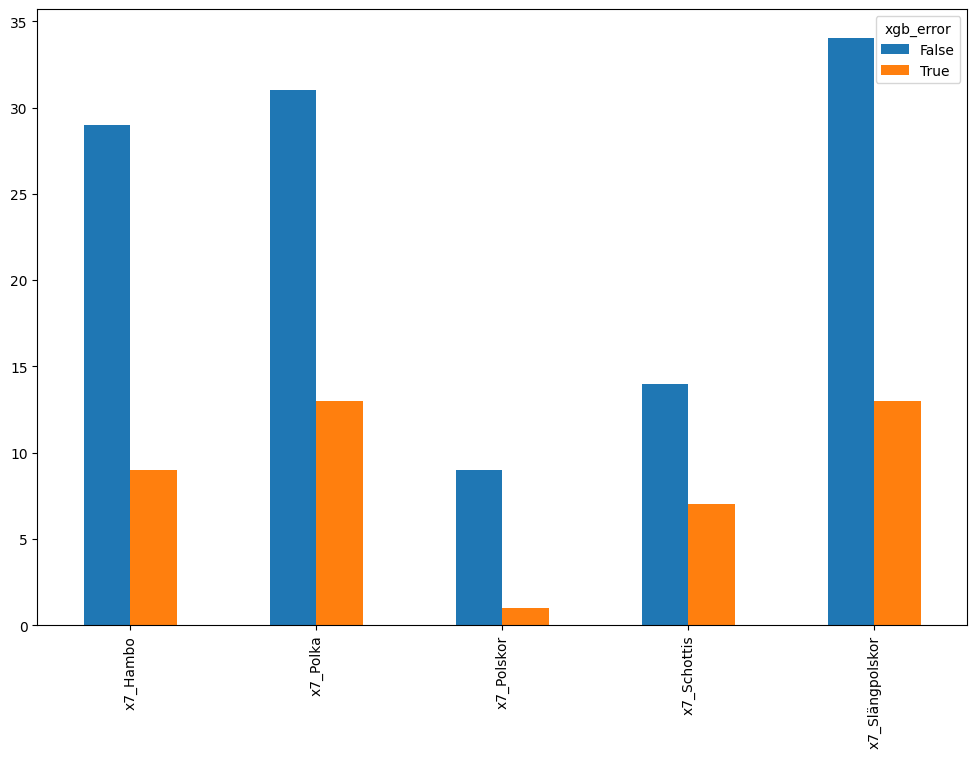

In [ ]:
#Plot error rate by columns starting with 'x7'
x7_cols = [col for col in df_val.columns if col.startswith('x7')]
cols = x7_cols
cols.append('xgb_error')

#Count relative error rate by column in x7_cols
df_val[cols].groupby('xgb_error').sum().T.plot(kind='bar', figsize=(12, 8))

In [168]:
df_train.loc[df_train['x7_Polskor'] == 1]

x7_Hambo  x7_Polka  x7_Polskor  x7_Schottis  x7_Slängpolskor  x12_True  \
28        0.0       0.0         1.0          0.0              0.0       1.0   
48        0.0       0.0         1.0          0.0              0.0       1.0   
61        0.0       0.0         1.0          0.0              0.0       0.0   
79        0.0       0.0         1.0          0.0              0.0       1.0   
116       0.0       0.0         1.0          0.0              0.0       1.0   
..        ...       ...         ...          ...              ...       ...   
952       0.0       0.0         1.0          0.0              0.0       1.0   
954       0.0       0.0         1.0          0.0              0.0       0.0   
955       0.0       0.0         1.0          0.0              0.0       1.0   
959       0.0       0.0         1.0          0.0              0.0       1.0   
977       0.0       0.0         1.0          0.0              0.0       1.0   

           x1        x2        x3        x4        x5        x6        x8  \
28   2.019998  0.809336 -0.721085 -0.362930  0.840093  0.995421 -0.553464   
48   1.884662  0.119599 -1.104523 -1.097846  1.260788 -0.278893  1.785356   
61   1.644984  2.947257 -0.233387  0.745684 -0.725919  2.078549 -0.251283   
79   2.705923  0.695693 -1.070494 -0.575816  0.363446  0.199254  0.439171   
116  2.277405 -0.783681 -0.233110  0.406378 -0.263931 -0.951598  0.302880   
..        ...       ...       ...       ...       ...       ...       ...   
952  2.040957  0.710268  1.243026  1.108969 -1.068650  1.007555 -0.968065   
954  1.704997  1.665803 -0.261589  1.003145 -0.990087  1.266032  0.551755   
955  2.321980  1.784835 -1.206456  1.077996 -1.094518  1.114941  1.362308   
959  1.779007  0.574048 -2.256063 -1.007789  0.800644  0.537088  0.385918   
977  1.517105  1.536007  2.180809  0.104111 -0.419835  1.948023 -0.341925   

           x9       x10       x11       x13  y  
28  -0.304744  1.416667 -0.529147  1.866942  1  
48   0.403612  2.582089  0.892774  1.590226  2  
61  -0.605415 -1.375090  1.067440  1.644601  2  
79  -0.619013 -0.192132 -0.544383  2.464164  1  
116  1.044527 -0.506738  0.100546  2.308490  2  
..        ...       ...       ...       ... ..  
952 -0.462185 -1.873644  1.547120  2.578742  2  
954  0.072636 -0.717538  0.971097  1.697688  0  
955  1.407143  0.843731 -1.415161  2.013435  1  
959 -1.255892 -2.673241  1.240799  1.074898  2  
977  0.712946  1.134732 -1.075950  2.358253  2  

[59 rows x 18 columns]

In [169]:
df_val.loc[df_train['x7_Polskor'] == 1]

IndexingError: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).